# Install our basic dependency

In [1]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.8/615.8 KB 17.1 MB/s eta 0:00:00


# IMPORTS

In [2]:
import tensorflow_datasets as tfds
import keras_cv as kcv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
# OXFORD-IIIT PETS DATASET
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteA675O4/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteA675O4/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Let's just look at what we have in terms of data

In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpoqy7331ntfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

We have 37 classes

In [4]:
x=tfds.as_dataframe(dataset['train'].take(2), info)

In [5]:
y=tfds.as_dataframe(dataset['test'].take(2), info)

In [6]:
x.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          2 non-null      object
 1   image              2 non-null      object
 2   label              2 non-null      int64 
 3   segmentation_mask  2 non-null      object
 4   species            2 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 208.0+ bytes


,file_name,image,label,segmentation_mask,species
0,Sphynx_158.jpg,,33 (Sphynx),,0 (Cat)
1,english_cocker_spaniel_135.jpg,,12 (english_cocker_spaniel),,1 (Dog)

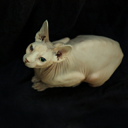
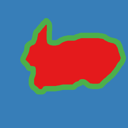
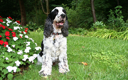
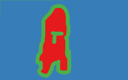

In [7]:
x

,file_name,image,label,segmentation_mask,species
0,leonberger_73.jpg,,19 (leonberger),,1 (Dog)
1,Maine_Coon_231.jpg,,20 (Maine_Coon),,0 (Cat)

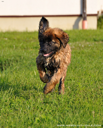
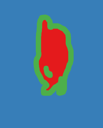
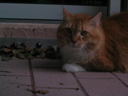
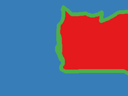

In [8]:
y

# PREPROCESSING

In [9]:
def normalize_image(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)/255.0 # input_image belongs to [0,1)
  input_mask -= 1 # classes {0,1,2}
  return input_image, input_mask

In [10]:
SHAPE = (256,256)
def load_image(x):
  # Added an additional parameter that I can use to change our
  input_image = tf.image.resize(x['image'], SHAPE)
  input_mask = tf.image.resize(
    x['segmentation_mask'],
    SHAPE,
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    #Nearest method interpolation is a method for resizing which considers the neighboring pixels as a filler
  )

  input_image, input_mask = normalize_image(input_image, input_mask)
  # Reference to above function that we just defined to normalize values
  return input_image, input_mask 

In [11]:
# load images from our dataset
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [156]:
# We want better training through several shifts in og images (using this to generate our great sets)
data_augmentationTr = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.3),
    ]
)
# Different augmentation for testing data since we want not too much overfitting on this "crazy randomization"
# data_augmentationTe = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomZoom(0.2),
#     ]
# )
# OR I'll hold back on the augmentation of random layers

In [13]:
class Augmentor(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Augmentor, self).__init__(**kwargs)
    def call(self, inputs,seed):
        # Use the seed value here to perform any desired operations on the inputs
        # ...
        # We want better training through several shifts in og images (using this to generate our great sets)
        self.seed = seed
        data_augmentationTr = tf.keras.Sequential(
         [
           tf.keras.layers.RandomFlip("horizontal",seed = self.seed),
           tf.keras.layers.RandomRotation(0.1,seed = self.seed),
           tf.keras.layers.RandomZoom(0.2,seed = self.seed),
          ]
        )
        
        outputs = data_augmentationTr(inputs)
        return outputs

In [14]:
tatorgator = Augmentor()
#shit naming sense
x = train_images.map(lambda x,y:(tatorgator.call(x,seed = 40),(tatorgator.call(y,seed=40))))

In [15]:
ct = 0
for i, m in x:
  if ct>=4:
    break
  display([i,m])
  ct+=1

[<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.02598105, 0.01786484, 0.01678673],
         [0.02854994, 0.02462687, 0.02628247],
         [0.02096763, 0.02187495, 0.02368025],
         ...,
         [0.01448883, 0.01626541, 0.02125296],
         [0.0133687 , 0.01889547, 0.01836   ],
         [0.01267395, 0.01977908, 0.01743357]],
 
        [[0.02417604, 0.01946656, 0.01437993],
         [0.02095458, 0.01900943, 0.01719355],
         [0.01701285, 0.01722463, 0.0159604 ],
         ...,
         [0.01649924, 0.01527732, 0.02020134],
         [0.01328013, 0.01587326, 0.01295234],
         [0.00897283, 0.01481395, 0.01085821]],
 
        [[0.01876407, 0.01807049, 0.01210917],
         [0.01879123, 0.01899064, 0.0129858 ],
         [0.0194839 , 0.02119709, 0.0150056 ],
         ...,
         [0.01718711, 0.01274077, 0.01884392],
         [0.01424053, 0.01227849, 0.01289492],
         [0.01199349, 0.01362118, 0.01158587]],
 
        ...,
 
        [[0.01914295, 0.02104802

[<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.11635911, 0.22720854, 0.09846797],
         [0.10745867, 0.20997894, 0.08033194],
         [0.12595686, 0.22278373, 0.09500773],
         ...,
         [0.14384775, 0.31147403, 0.11183191],
         [0.3493077 , 0.4787243 , 0.34756583],
         [0.42526397, 0.52346444, 0.40435463]],
 
        [[0.08695643, 0.16140717, 0.04831004],
         [0.07940853, 0.14321606, 0.0358445 ],
         [0.08247803, 0.15571815, 0.04366334],
         ...,
         [0.1814096 , 0.3498586 , 0.13047291],
         [0.17100279, 0.333377  , 0.12132315],
         [0.2954997 , 0.37609592, 0.2650924 ]],
 
        [[0.0820962 , 0.15431042, 0.03219559],
         [0.07610669, 0.13656113, 0.02934837],
         [0.0599811 , 0.1291388 , 0.03144617],
         ...,
         [0.11660554, 0.1901296 , 0.07118125],
         [0.1131419 , 0.18192032, 0.0641863 ],
         [0.1258442 , 0.14399944, 0.08375297]],
 
        ...,
 
        [[0.5803418 , 0.7642202 

[<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.6183117 , 0.44969925, 0.2134598 ],
         [0.61468816, 0.44499514, 0.2119455 ],
         [0.61823255, 0.44448853, 0.21098982],
         ...,
         [0.18664968, 0.13036376, 0.02559391],
         [0.18789238, 0.12953784, 0.02606335],
         [0.18893853, 0.13166149, 0.02713452]],
 
        [[0.6390065 , 0.46604156, 0.22138476],
         [0.6317374 , 0.45796362, 0.2192306 ],
         [0.6235939 , 0.45053753, 0.21343185],
         ...,
         [0.19020846, 0.130704  , 0.02918507],
         [0.18934599, 0.12912329, 0.02828672],
         [0.1900867 , 0.13051613, 0.02728103]],
 
        [[0.6415974 , 0.46658316, 0.2299368 ],
         [0.6322352 , 0.4582541 , 0.22663316],
         [0.6178195 , 0.4455269 , 0.21223792],
         ...,
         [0.19131766, 0.1298536 , 0.03087535],
         [0.18908776, 0.13049467, 0.03013283],
         [0.18845634, 0.13183247, 0.02823108]],
 
        ...,
 
        [[0.66750795, 0.2825636 

[<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.3531344 , 0.43912017, 0.37762752],
         [0.35478023, 0.4430719 , 0.37887698],
         [0.35184008, 0.44141448, 0.3829951 ],
         ...,
         [0.14983204, 0.17706352, 0.12247729],
         [0.14517578, 0.17612326, 0.11951785],
         [0.14608316, 0.17276578, 0.1213301 ]],
 
        [[0.35169572, 0.4390837 , 0.375596  ],
         [0.3495149 , 0.44032383, 0.37476793],
         [0.34791166, 0.44172847, 0.37944287],
         ...,
         [0.14520633, 0.17514192, 0.1309731 ],
         [0.14326929, 0.17696236, 0.12765174],
         [0.14306659, 0.17826764, 0.12747847]],
 
        [[0.35074532, 0.4403463 , 0.38102207],
         [0.35094583, 0.44150054, 0.37927505],
         [0.34887958, 0.44365808, 0.37877142],
         ...,
         [0.1470138 , 0.17506753, 0.13518918],
         [0.14799981, 0.17582823, 0.131511  ],
         [0.149569  , 0.17763676, 0.12955377]],
 
        ...,
 
        [[0.7307186 , 0.7254404 

In [44]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [149]:
train_batch = train_images.batch(BATCH_SIZE)
train_batchmod = x.batch(BATCH_SIZE)
test_batch = test_images.batch(BATCH_SIZE)

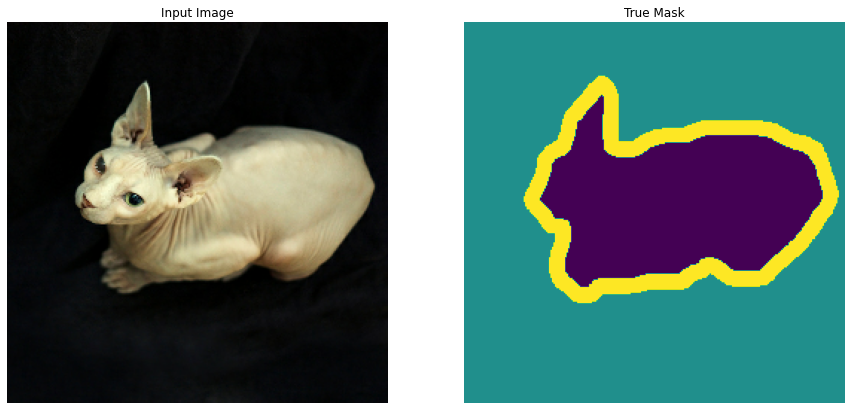

In [37]:
def display(images):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  # 3 different image types
  for i in range(len(images)):
    # per image
    plt.subplot(1, len(images), i+1)
    plt.title(title[i])
    # Smart implementation since we don't have to care about the predicted mask not existing yet
    plt.imshow(tf.keras.utils.array_to_img(images[i]))
    plt.axis('off') 
  plt.show()
for images, masks in train_batch.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


# Set our model

In [38]:
!pip install keras.applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
imagemodel = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[256,256,3], # We converted the images to 256 by 256
)


In [40]:
imagemodel.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

Using this efficient net V2l for transfer learning (model has a high accuracy to size ratio)

In [123]:
layer_names = [
    'rescaling_1',   # ->128*128
    'block1d_add',#->64
    'block2g_add',   # ->32
    'block4a_expand_activation',   #->16x16
    'block6a_expand_activation',   # ->8   
]
base_model_outputs = [imagemodel.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=imagemodel.input, outputs=base_model_outputs)
down_stack.trainable = False
# Set Trainable to false since we don't want to retrain the given model
# Test with trainable predata

Creating a UNet Architecture so we've to do an downsampler and an upsampler. Referringto the image segmentation tutorial here in keras.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git


In [139]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    # pix2pix.upsample(32, 3),   # 64x64 -> 128x128
]
# Pix2pix is used to upsample our output (it's another model that helps with the task)

In [140]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  skips = down_stack(inputs)
  x = skips[-1] # Preparing our first skip connection
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  # concatenation of all the upsampling layers with the skips

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=1,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [144]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


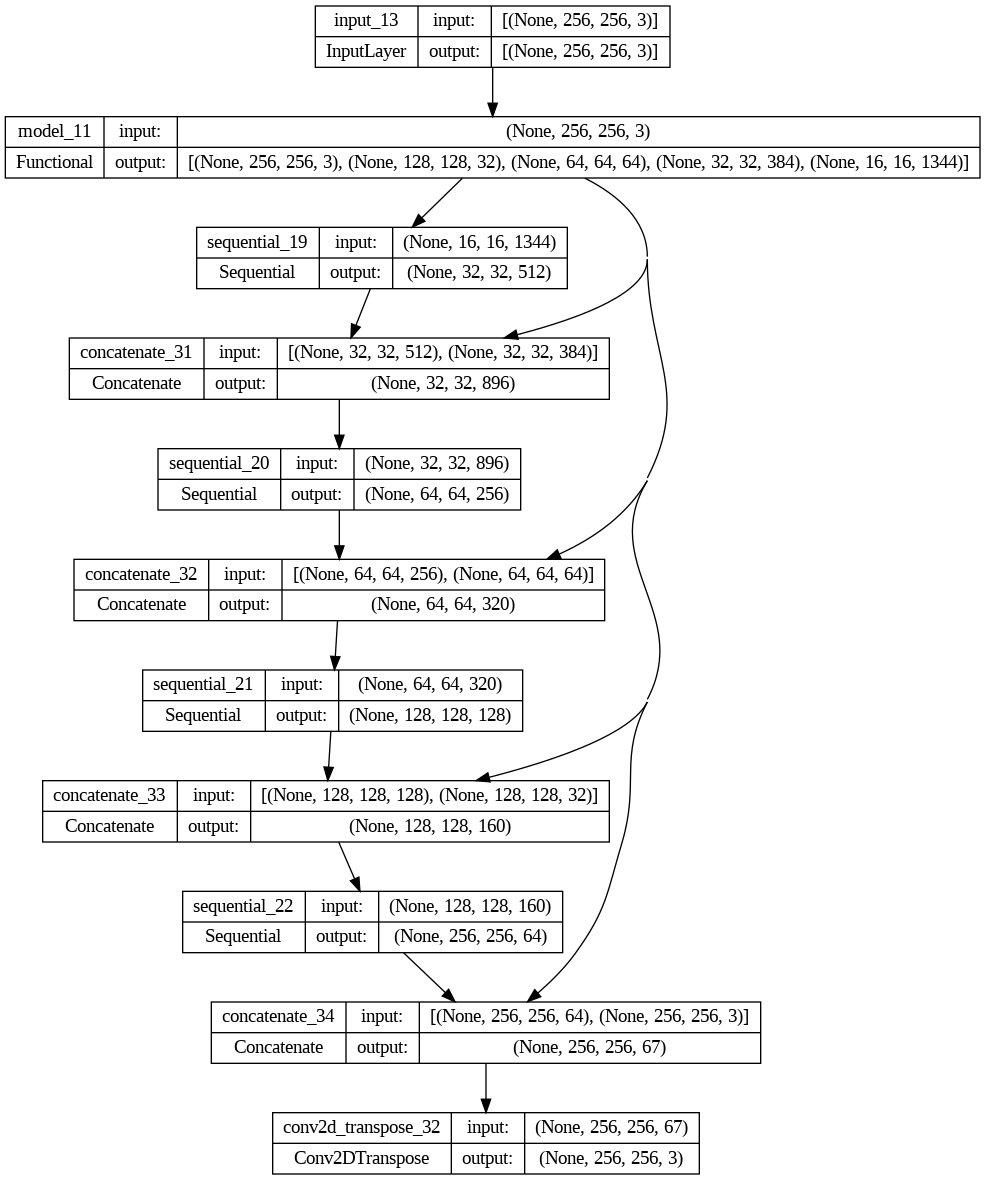

In [145]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [132]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [128]:
def show_predictions(dataset=None, num=2):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0],create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 3s 3s/step


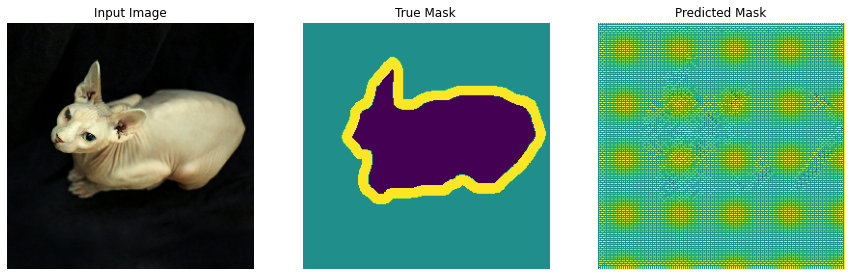

In [143]:
show_predictions()

In [147]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [157]:
def normal_train(EPOCHS): 
  VAL_SUBSPLITS = 5
  VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
  model_history = model.fit(train_batch, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_batch,
                            callbacks=[DisplayCallback()])
def mod_train(EPOCHS):
  seed = random_int = tf.random.uniform(shape=(), minval=1, maxval=50, dtype=tf.int32)
  x = train_images.map(lambda x,y:(tatorgator.call(x,seed),(tatorgator.call(y,seed))))
  train_batchmod = x.batch(BATCH_SIZE)
  VAL_SUBSPLITS = 5
  VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
  model_history = model.fit(train_batchmod, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_batch,
                            callbacks=[DisplayCallback()])

Epoch 1/2
1/1 [==============================] - 0s 39ms/step


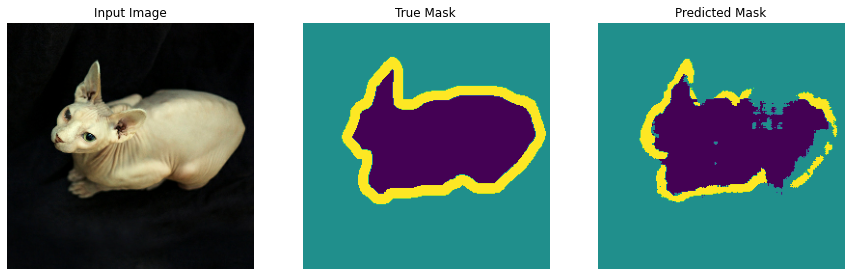


Sample Prediction after epoch 1

115/115 [==============================] - 110s 953ms/step - loss: 0.4945 - accuracy: 0.8031 - val_loss: 0.5289 - val_accuracy: 0.7875
Epoch 2/2
1/1 [==============================] - 0s 37ms/step


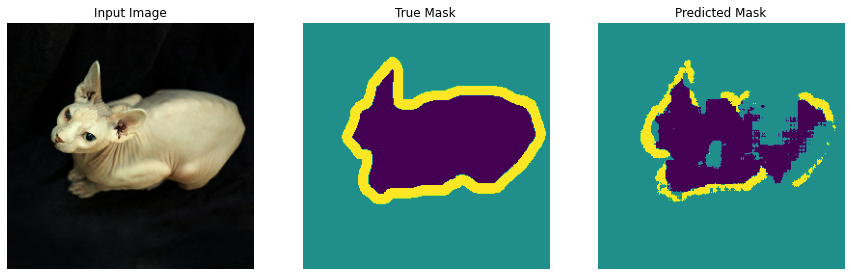


Sample Prediction after epoch 2

1/1 [==============================] - 0s 37ms/step


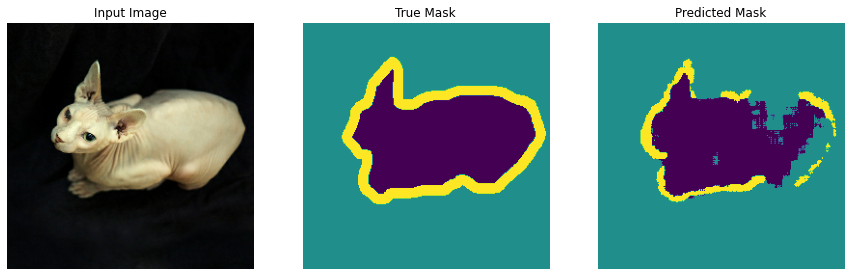


Sample Prediction after epoch 1

115/115 [==============================] - 110s 953ms/step - loss: 0.4917 - accuracy: 0.8043 - val_loss: 0.5551 - val_accuracy: 0.7821
Epoch 1/2
1/1 [==============================] - 0s 36ms/step


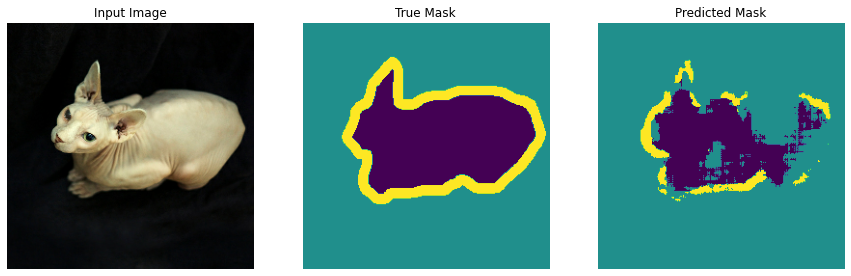


Sample Prediction after epoch 1

115/115 [==============================] - 110s 952ms/step - loss: 0.4903 - accuracy: 0.8050 - val_loss: 0.6691 - val_accuracy: 0.7356
Epoch 2/2
1/1 [==============================] - 0s 37ms/step


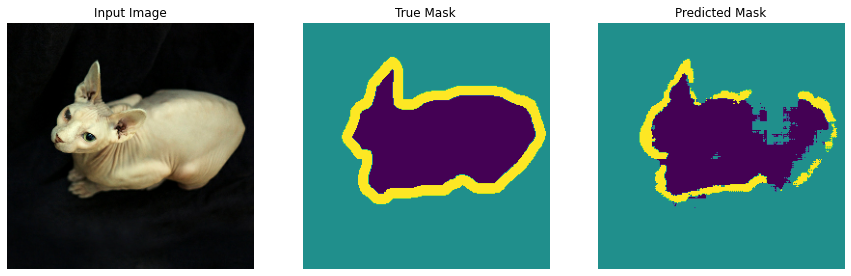


Sample Prediction after epoch 2

115/115 [==============================] - 110s 955ms/step - loss: 0.4906 - accuracy: 0.8047 - val_loss: 0.5161 - val_accuracy: 0.7930
Epoch 1/2
1/1 [==============================] - 0s 36ms/step


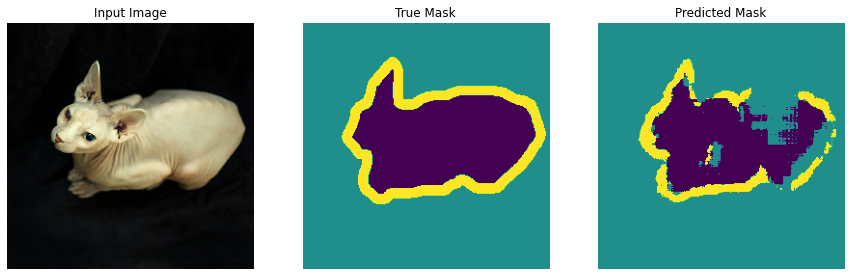


Sample Prediction after epoch 1

115/115 [==============================] - 110s 954ms/step - loss: 0.4880 - accuracy: 0.8058 - val_loss: 0.5420 - val_accuracy: 0.7767
Epoch 2/2
1/1 [==============================] - 0s 35ms/step


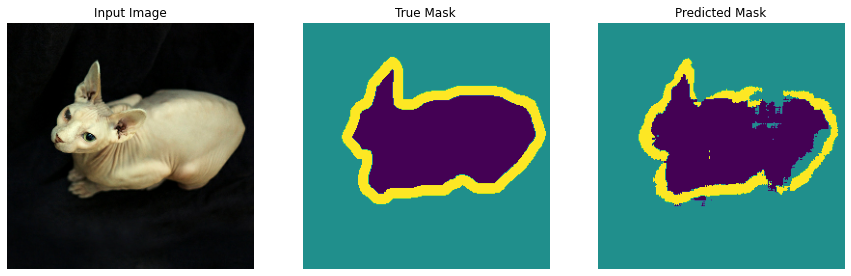


Sample Prediction after epoch 2

1/1 [==============================] - 0s 54ms/step


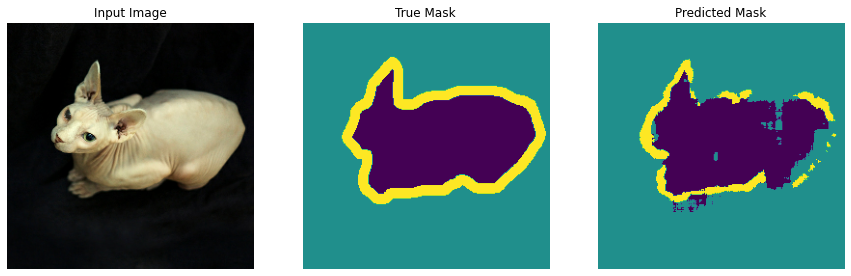


Sample Prediction after epoch 1

115/115 [==============================] - 110s 955ms/step - loss: 0.4863 - accuracy: 0.8063 - val_loss: 0.5189 - val_accuracy: 0.7939
Epoch 1/2
1/1 [==============================] - 0s 36ms/step


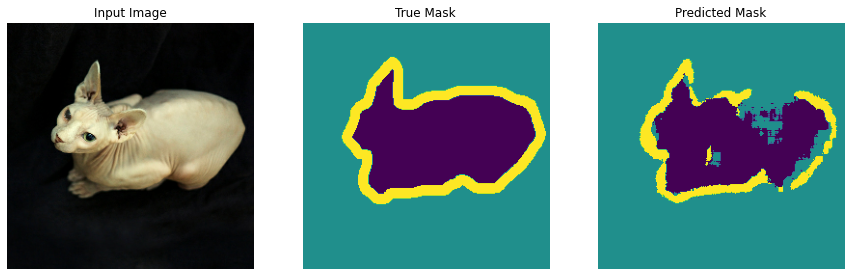


Sample Prediction after epoch 1

115/115 [==============================] - 110s 955ms/step - loss: 0.4840 - accuracy: 0.8073 - val_loss: 0.5248 - val_accuracy: 0.7882
Epoch 2/2
1/1 [==============================] - 0s 35ms/step


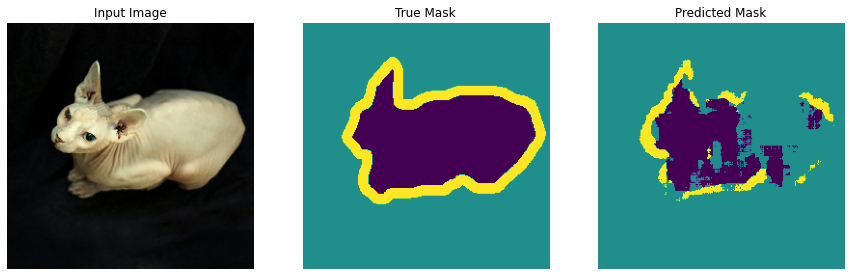


Sample Prediction after epoch 2

115/115 [==============================] - 110s 954ms/step - loss: 0.4838 - accuracy: 0.8074 - val_loss: 0.7275 - val_accuracy: 0.7194
Epoch 1/2
1/1 [==============================] - 0s 37ms/step


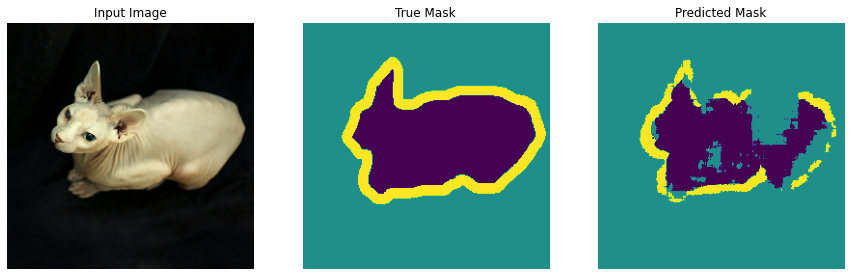


Sample Prediction after epoch 1

115/115 [==============================] - 110s 957ms/step - loss: 0.4835 - accuracy: 0.8075 - val_loss: 0.5969 - val_accuracy: 0.7535
Epoch 2/2
1/1 [==============================] - 0s 37ms/step


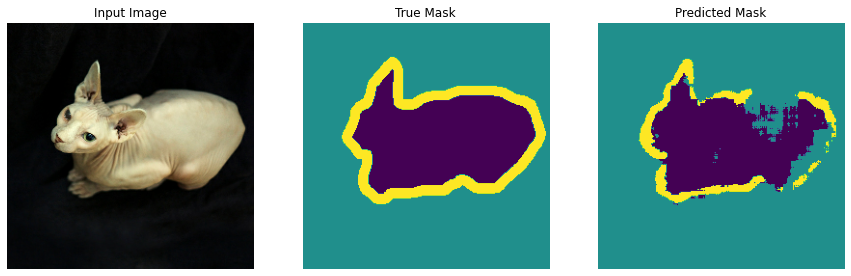


Sample Prediction after epoch 2

115/115 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.8081

In [ ]:
for i in range(30):
  mod_train(2)
  normal_train(1)
  mod_train(2)

In [1]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

NameError: ignored

In [91]:
import numpy as np
from sklearn.metrics import log_loss
def pixel_cross_entropy(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    return log_loss(y_true, y_pred)

1/1 [==============================] - 0s 126ms/step


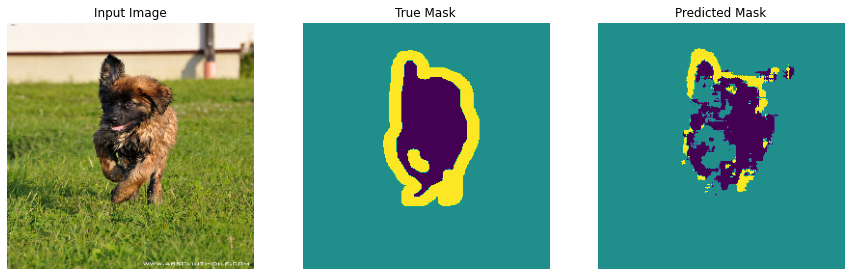

1/1 [==============================] - 0s 96ms/step


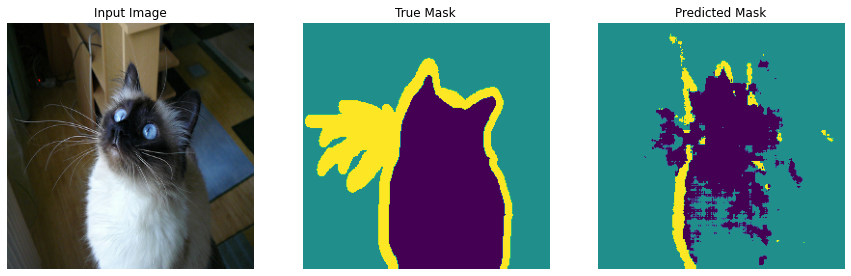

1/1 [==============================] - 0s 46ms/step


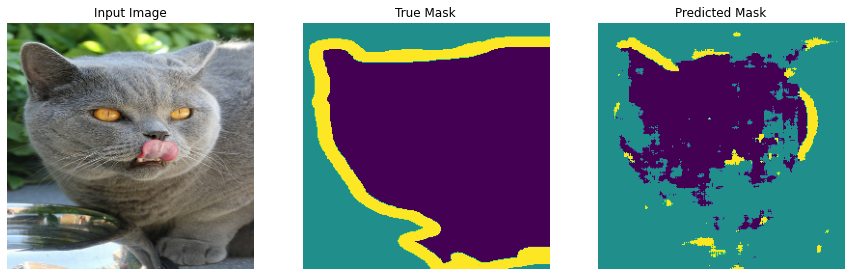

In [155]:
show_predictions(test_batch, 3)